数据导入

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("station-data\\PRSA_Data_Tiantan_20130301-20170228.csv")
# 合并时间列
df['Date'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['day'].astype(str) + '-' + df['hour'].astype(str)

df = df[['Date', 'TEMP']].copy()

df.head()

,Date,TEMP
0,2013-3-1-0,-0.5
1,2013-3-1-1,-0.7
2,2013-3-1-2,-1.2
3,2013-3-1-3,-1.4
4,2013-3-1-4,-1.9


数据预处理

1.处理缺失值

In [11]:
print(df.isnull().sum())    # 返回每一列中的缺失值（NaN）的数量
print(df.isnull().any(axis=1))  # 返回一个布尔序列，标识每一行是否含有缺失值
print(df.iloc[105])   # 查看具体某一行的值，可以通过索引或者iloc属性来实现
print(df.iloc[106])

Date     0
TEMP    20
dtype: int64
0        False
1        False
2        False
3        False
4        False
         ...  
35059    False
35060    False
35061    False
35062    False
35063    False
Length: 35064, dtype: bool
Date    2013-3-5-9
TEMP           6.7
Name: 105, dtype: object
Date    2013-3-5-10
TEMP            9.1
Name: 106, dtype: object


In [14]:
#找出有缺失值的行  data[["data"]].isnull().T.any().values
def knm(df,n):
    #找出缺失值的行
    temp = df.isnull().T.any().values
    temp_df = df.copy()
    for i in range(len(temp)):
        if temp[i] == True:
            if i < n-1:                  #前n个
                 temp_df.loc[i,'TEMP'] = df.loc[i:i+n,'TEMP'].mean()  
            elif i > len(temp) - 1 -n:     #后n个
                 temp_df.loc[i,'TEMP'] = df.loc[i-n:i,'TEMP']
            else:
                 temp_df.loc[i,'TEMP'] = df.loc[i-n:i+n,'TEMP'].mean()
    return temp_df
not_miss = knm(df[['TEMP']],2)
df['TEMP'] = not_miss.values

In [15]:
print(df.isnull().sum())    # 返回每一列中的缺失值（NaN）的数量
print(df.isnull().any(axis=1))  # 返回一个布尔序列，标识每一行是否含有缺失值
print(df.iloc[105])   # 查看具体某一行的值，可以通过索引或者iloc属性来实现
print(df.iloc[106])

Date    0
TEMP    0
dtype: int64
0        False
1        False
2        False
3        False
4        False
         ...  
35059    False
35060    False
35061    False
35062    False
35063    False
Length: 35064, dtype: bool
Date    2013-3-5-9
TEMP           6.7
Name: 105, dtype: object
Date    2013-3-5-10
TEMP            9.1
Name: 106, dtype: object


处理日期类型

In [16]:
# 2. 数据类型转换
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 3. 设定索引
df = df.set_index('Date')

# 4. 检查数据排序
df = df.sort_index()

df.head()

,TEMP
Date,
2013-03-01 00:00:00,-0.5
2013-03-01 01:00:00,-0.7
2013-03-01 02:00:00,-1.2
2013-03-01 03:00:00,-1.4
2013-03-01 04:00:00,-1.9


数据分析

1.探索性数据分析（EDA）

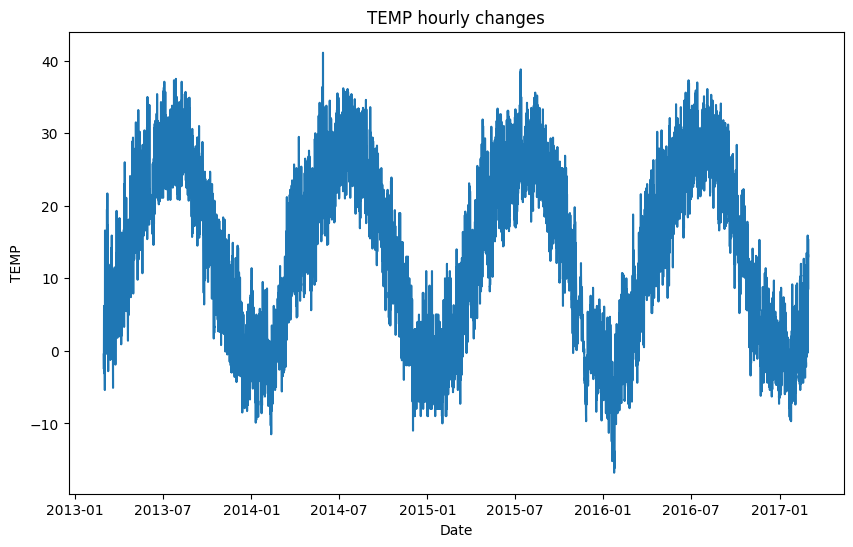

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['TEMP'])
plt.xlabel('Date')
plt.ylabel('TEMP')
plt.title('TEMP hourly changes')
plt.show()

2.ADF单位根检验

In [21]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['TEMP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.843366
p-value: 0.002494
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


3.差分

In [24]:
# 首先导入了所需要的库和函数
from statsmodels.tsa.stattools import adfuller

# 定义一个名为calculate_diff的函数，接收三个参数：df是要处理的DataFrame，max_diff是最大的差分步数，significance_level是判定平稳性的显著性水平
def calculate_diff(df, max_diff, significance_level=0.05):
    # 初始化最佳差分阶数和最小p值
    best_diff = None
    min_pvalue = 1.0
    min_variance = float('inf')  # 初始化最小方差
    min_adf_stat = float('inf')  # 初始化最小ADF统计量

    # 原数据
    # 对数据进行ADF单位根检验
    result = adfuller(df)
    # 打印出差分阶数，ADF统计量，p值，标准差和方差
    print('原数据')
    print('ADF统计量: %f' % result[0])
    print('p值: %.10e' % result[1])  
    print('标准差: %f' % df.std())
    print('方差: %f' % df.var())

    # 判断p值是否小于显著性水平，如果小于则认为差分后的数据可能是平稳的
    if result[1] < significance_level:
        print('=> 根据这个差分阶数，序列可能是平稳的')
        # 判断当前的p值是否小于最小p值，如果小于则更新最小p值和最佳差分阶数
        if result[1] < min_pvalue:
            min_pvalue = result[1]
            best_diff = 0
            min_variance = df.var()  # 更新最小方差
            min_adf_stat = result[0]  # 更新最小ADF统计量
    else:
        print('=> 根据这个差分阶数，序列可能是非平稳的')
    print('--------------------------------')

    # 循环，差分阶数从1到max_diff
    for i in range(1, max_diff+1):
        # 对数据进行差分，并去除NA值
        df_diff = df['TEMP'].diff(i).dropna()  
        # 对差分后的数据进行ADF单位根检验
        result = adfuller(df_diff)
        # 打印出差分阶数，ADF统计量，p值，标准差和方差
        print(f'{i}步差分')
        print('ADF统计量: %f' % result[0])
        print('p值: %.10e' % result[1])  
        print('标准差: %f' % df_diff.std())
        print('方差: %f' % df_diff.var())

        # 判断p值是否小于显著性水平，如果小于则认为差分后的数据可能是平稳的
        if result[1] < significance_level:
            print('=> 根据这个差分阶数，序列可能是平稳的')
            # 判断当前的p值是否小于最小p值，如果小于则更新最小p值和最佳差分阶数
            if result[1] < min_pvalue:
                min_pvalue = result[1]
                best_diff = i
                min_variance = df_diff.var()  # 更新最小方差
                min_adf_stat = result[0]  # 更新最小ADF统计量
        else:
            print('=> 根据这个差分阶数，序列可能是非平稳的')
        print('--------------------------------')

    # 如果找到了使数据平稳的差分阶数，打印出最佳差分阶数和其对应的p值
    if best_diff is not None:
        print(f'最佳差分阶数是: {best_diff}，p值为: {min_pvalue}，方差为: {min_variance}，ADF统计量为: {min_adf_stat}')

# 使用函数对数据进行差分并测试其平稳性
calculate_diff(df, max_diff=24)

原数据
ADF统计量: -3.843366
p值: 2.4935190886e-03
标准差: 11.459691
方差: 131.324527
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------


C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_13652\2435465979.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('标准差: %f' % df.std())
C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_13652\2435465979.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('方差: %f' % df.var())


1步差分
ADF统计量: -32.396699
p值: 0.0000000000e+00
标准差: 1.234991
方差: 1.525203
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
2步差分
ADF统计量: -31.737930
p值: 0.0000000000e+00
标准差: 2.152734
方差: 4.634262
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
3步差分
ADF统计量: -32.021732
p值: 0.0000000000e+00
标准差: 2.974611
方差: 8.848308
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
4步差分
ADF统计量: -30.886616
p值: 0.0000000000e+00
标准差: 3.717633
方差: 13.820799
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
5步差分
ADF统计量: -31.301562
p值: 0.0000000000e+00
标准差: 4.380248
方差: 19.186576
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
6步差分
ADF统计量: -31.619734
p值: 0.0000000000e+00
标准差: 4.961187
方差: 24.613373
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
7步差分
ADF统计量: -31.662052
p值: 0.0000000000e+00
标准差: 5.456790
方差: 29.776555
=> 根据这个差分阶数，序列可能是平稳的
--------------------------------
8步差分
ADF统计量: -31.398314
p值: 0.0000000000e+00
标准差: 5.864940
方差: 34.397516
=> 根据这个差分阶数，序列可能是平稳的
--------------------

4.绘制差分后的图像

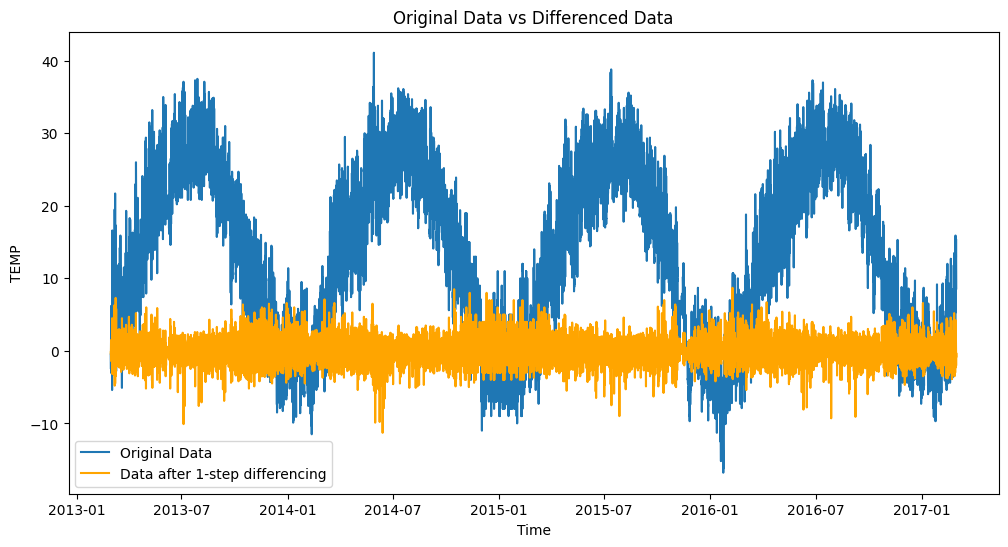

In [25]:
import matplotlib.pyplot as plt

# 设置1步差分
diff_steps = 1
df_diff = df['TEMP'].diff(diff_steps).dropna()

plt.figure(figsize=(12,6))

# 绘制原始数据
plt.plot(df['TEMP'], label='Original Data')

# 绘制1步差分后的数据
plt.plot(df_diff, label=f'Data after {diff_steps}-step differencing', color='orange')

# 设置标题和标签
plt.title('Original Data vs Differenced Data')
plt.xlabel('Time')
plt.ylabel('TEMP')

plt.legend()

plt.show()

In [27]:
df['TEMP_Diff_1'] = df['TEMP'].diff(1)

模型选择

1.分析ACF及PACF

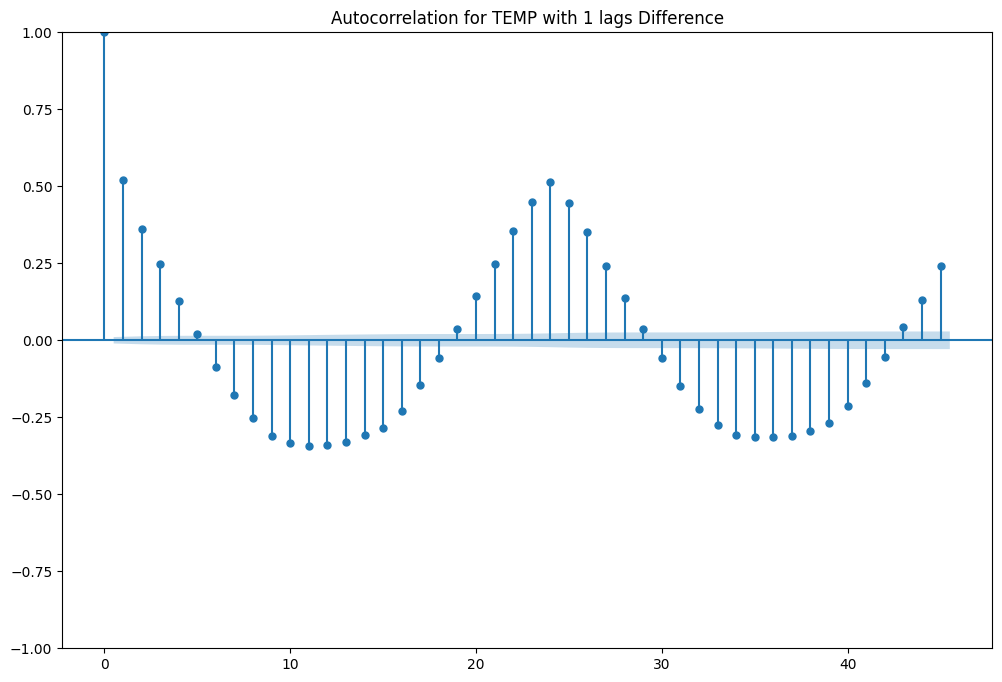

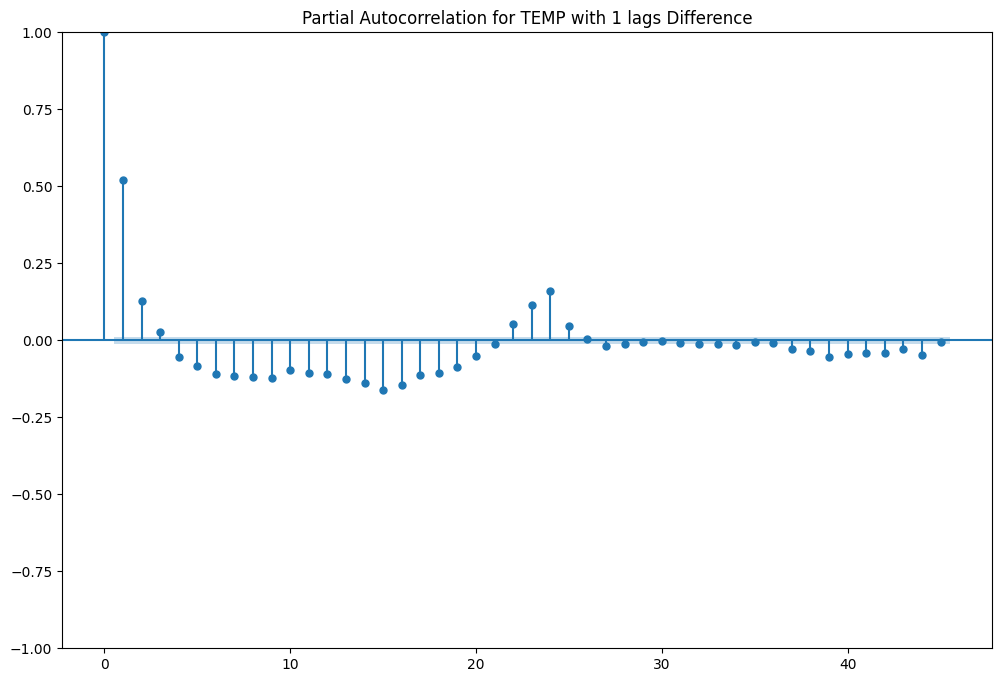

In [28]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 绘制ACF图
plt.figure(figsize=(12,8))
plot_acf(df['TEMP_Diff_1'].dropna(), lags=45, ax=plt.gca())
plt.title('Autocorrelation for TEMP with 1 lags Difference')
plt.show()

# 绘制PACF图
plt.figure(figsize=(12,8))
plot_pacf(df['TEMP_Diff_1'].dropna(), lags=45, ax=plt.gca())
plt.title('Partial Autocorrelation for TEMP with 1 lags Difference')
plt.show()

2.使用多阶差分确定d值

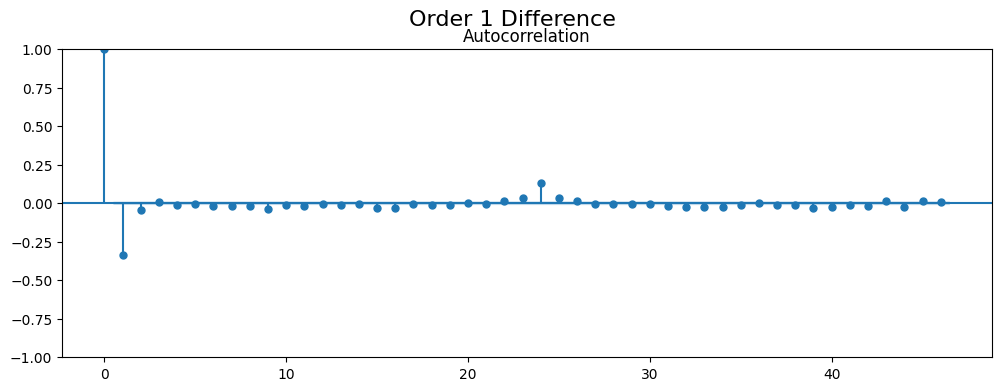

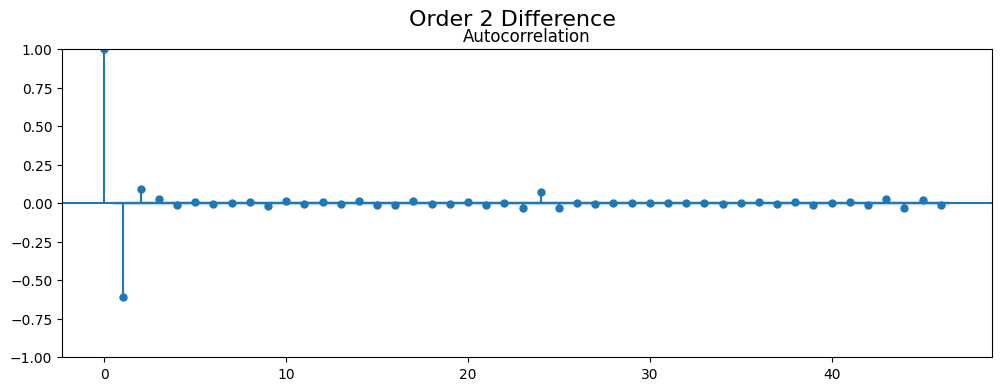

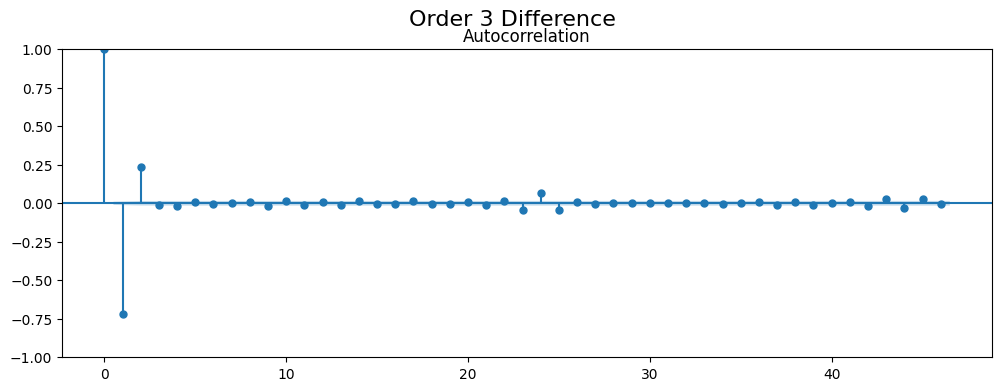

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np

def diff(data, order):
    if order == 0:
        return data
    else:
        return diff(data.diff().dropna(), order - 1)

# 循环不同的d值
for d in range(1, 4):
    # 创建新的图形
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Order {d} Difference', fontsize=16)

    # 绘制ACF图
    plot_acf(diff(df['TEMP_Diff_1'], d), ax=plt.gca(), title='Autocorrelation')
    plt.show()

ARIMA模型实现

1.设置时间索引

In [31]:
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
df.index

DatetimeIndex(['2013-03-01 00:00:00', '2013-03-01 01:00:00',
               '2013-03-01 02:00:00', '2013-03-01 03:00:00',
               '2013-03-01 04:00:00', '2013-03-01 05:00:00',
               '2013-03-01 06:00:00', '2013-03-01 07:00:00',
               '2013-03-01 08:00:00', '2013-03-01 09:00:00',
               ...
               '2017-02-28 14:00:00', '2017-02-28 15:00:00',
               '2017-02-28 16:00:00', '2017-02-28 17:00:00',
               '2017-02-28 18:00:00', '2017-02-28 19:00:00',
               '2017-02-28 20:00:00', '2017-02-28 21:00:00',
               '2017-02-28 22:00:00', '2017-02-28 23:00:00'],
              dtype='datetime64[ns]', length=35064, freq='h')

2.获取不同的p、d、q组合

In [34]:
import itertools
#定义p, d和q参数，取0到4之间的任意值
p = q = range(0, 4)

# 生成p, d和q三元组的所有不同组合
pdq = [(x[0], 0, x[1]) for x in list(itertools.product(p, q))]
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3)]

3.超参数搜索

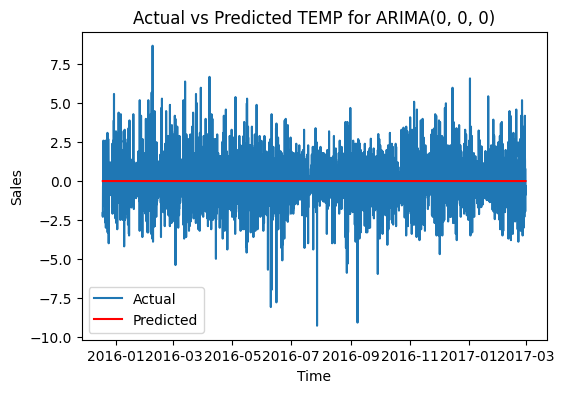

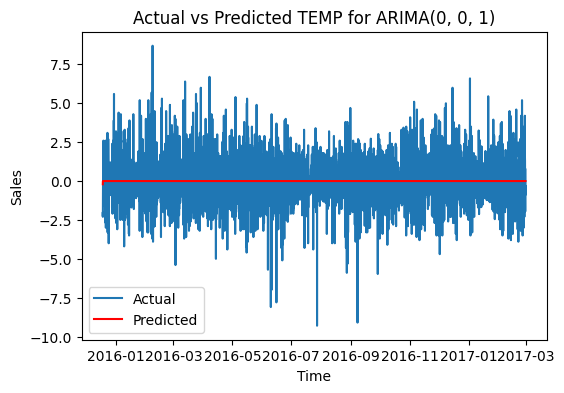

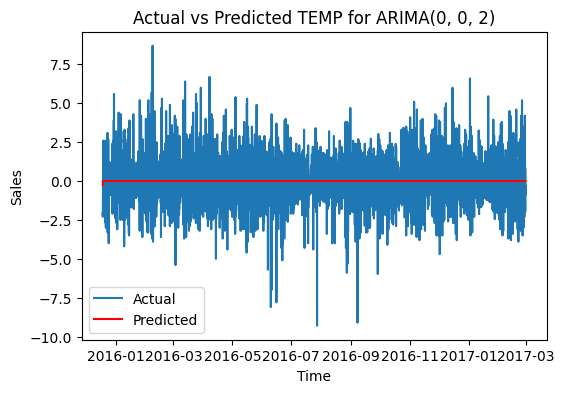

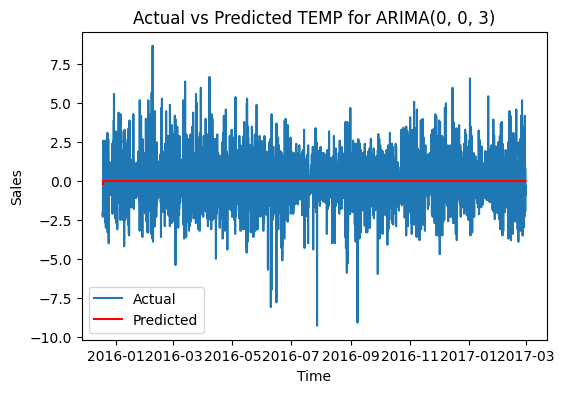

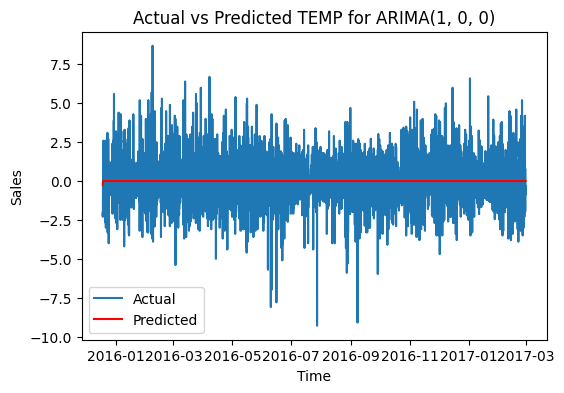

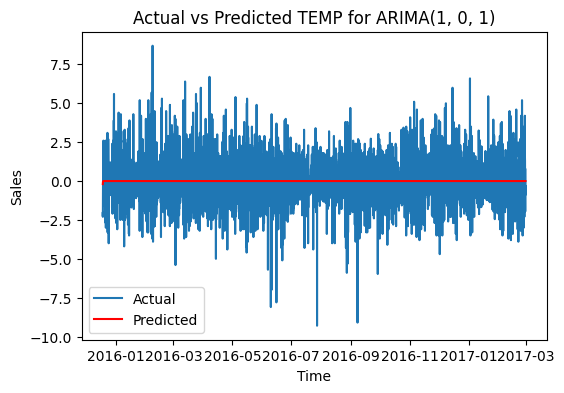

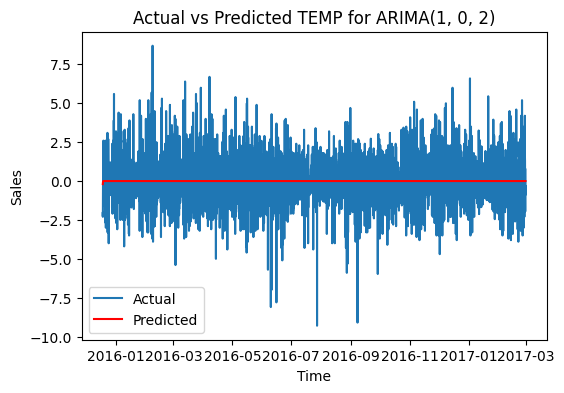

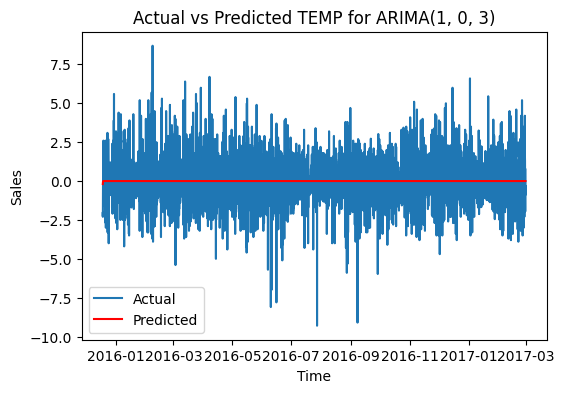

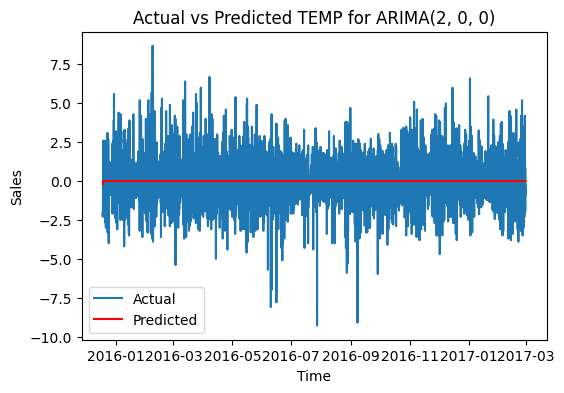

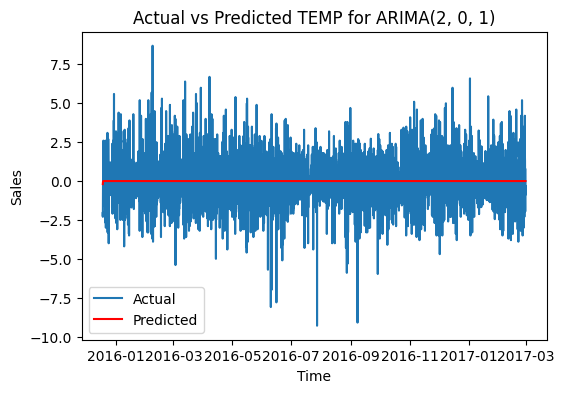

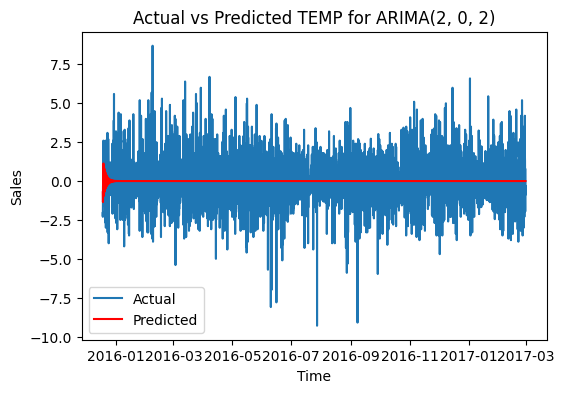

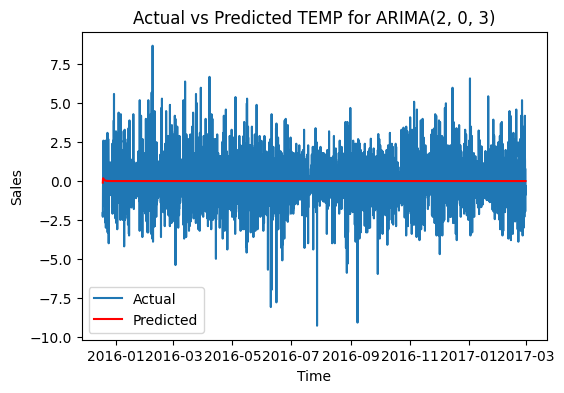

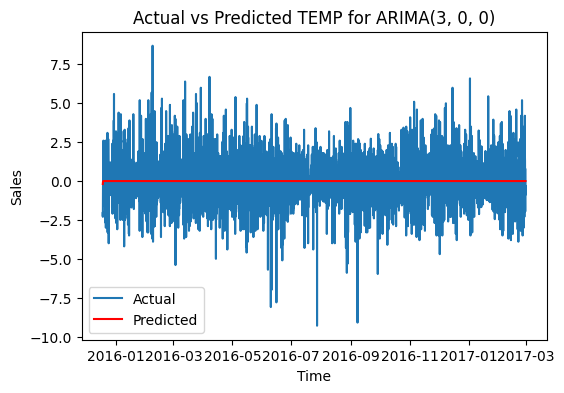

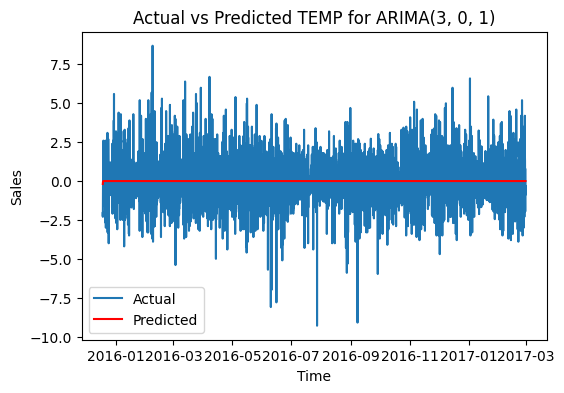

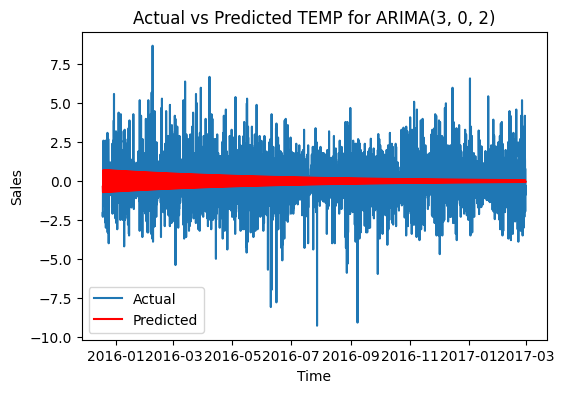

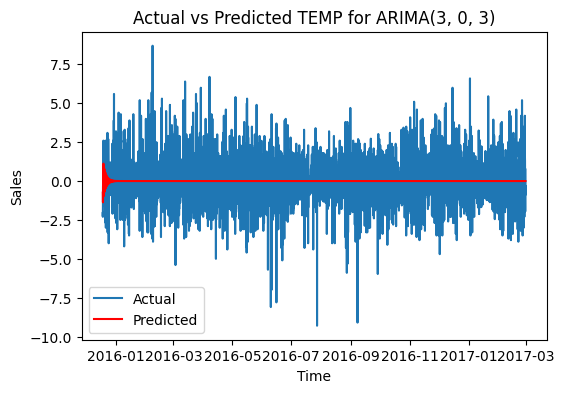

The best model is ARIMA(3, 0, 2), MSE = 1.1858482634294896
                               SARIMAX Results                                
Dep. Variable:            TEMP_Diff_1   No. Observations:                24545
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -33896.949
Date:                Sat, 24 Feb 2024   AIC                          67807.899
Time:                        10:28:17   BIC                          67864.656
Sample:                    03-01-2013   HQIC                         67826.286
                         - 12-18-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.433e-06      0.008     -0.000      1.000      -0.016       0.016
ar.L1          2.1816      0.004    511.015      0.000       2.173      

In [44]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import itertools

#定义p, d和q参数，取0到4之间的任意值
p = q = range(0, 4)

# 生成p, d和q三元组的所有不同组合
pdq = [(x[0], 0, x[1]) for x in list(itertools.product(p, q))]


# 将数据分为训练集和测试集
train_data = df['TEMP_Diff_1'].iloc[:24545]
test_data = df['TEMP_Diff_1'].iloc[24545:]


# 初始化最佳模型及其参数和MSE值
best_model = None
best_param = None
best_mse = float('inf')

# 对每一种参数组合进行迭代
for param in pdq:
    try:
        # 实例化ARIMA模型
        model = ARIMA(train_data, order=param)
        model_fit = model.fit()

        # 进行预测
        predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

        # 计算MSE
        mse = mean_squared_error(test_data, predictions)

        # 如果当前模型的MSE比最佳MSE小，更新最佳模型、参数和MSE
        if mse < best_mse:
            best_model = model_fit
            best_param = param
            best_mse = mse

        # 绘制真实值和预测值
        plt.figure(figsize=(6, 4))
        plt.plot(df.index[24545:], df['TEMP_Diff_1'].iloc[24545:], label='Actual')
        plt.plot(df.index[24545:], predictions, color='red', label='Predicted')

        # 添加标题和标签
        plt.title('Actual vs Predicted TEMP for ARIMA{}'.format(param))
        plt.xlabel('Time')
        plt.ylabel('Sales')
        plt.legend()

        # 显示图形
        plt.show()

    except Exception as e:
        print('Error:', e)
        continue

# 打印出最优模型的参数及其MSE
print(f'The best model is ARIMA{best_param}, MSE = {best_mse}')

# 打印最优模型的摘要
print(best_model.summary(alpha=0.05))

SARIMA模型实现

ARIMA(0, 1, 0, 12) - AIC:163284.51976166866


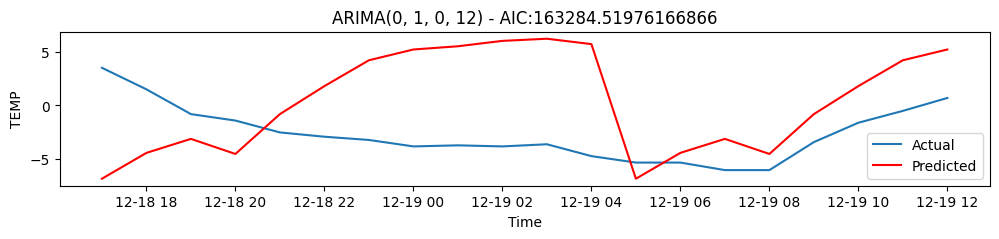

ARIMA(0, 1, 1, 12) - AIC:141990.56873459645


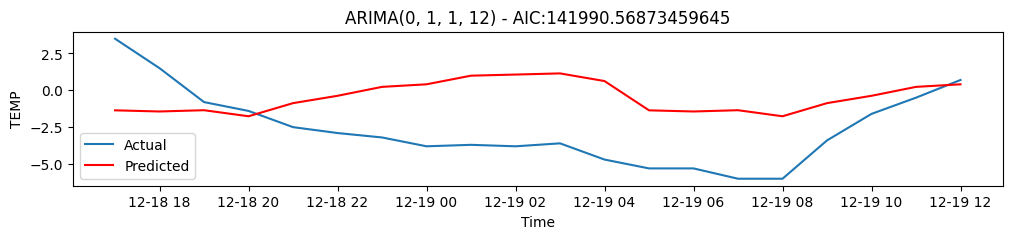

ARIMA(0, 1, 2, 12) - AIC:138593.95497548263


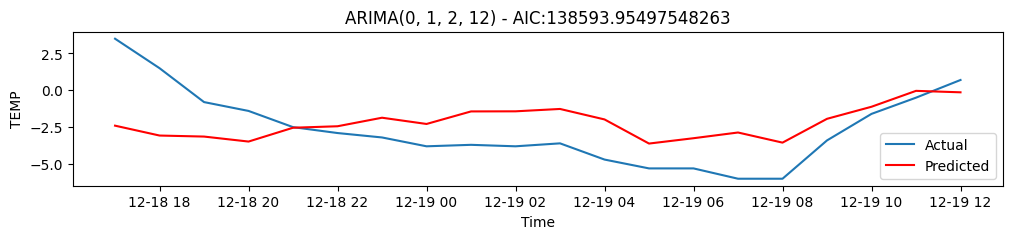

ARIMA(1, 1, 0, 12) - AIC:127798.48757821927


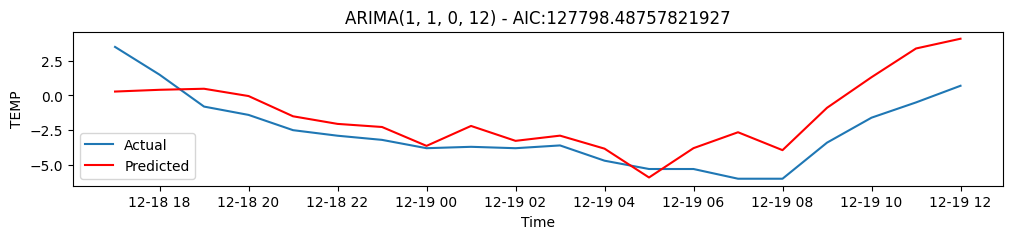

ARIMA(1, 1, 1, 12) - AIC:126566.09212278604


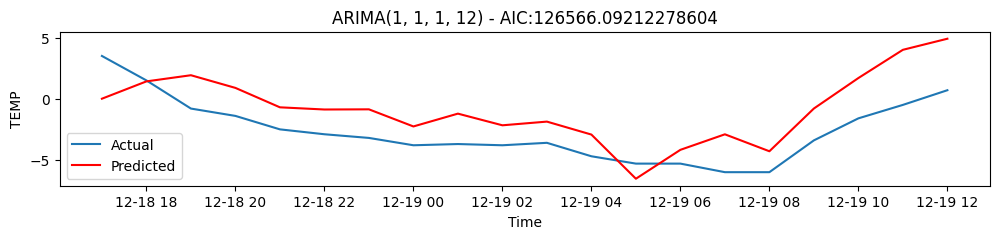

ARIMA(1, 1, 2, 12) - AIC:121602.31889518054


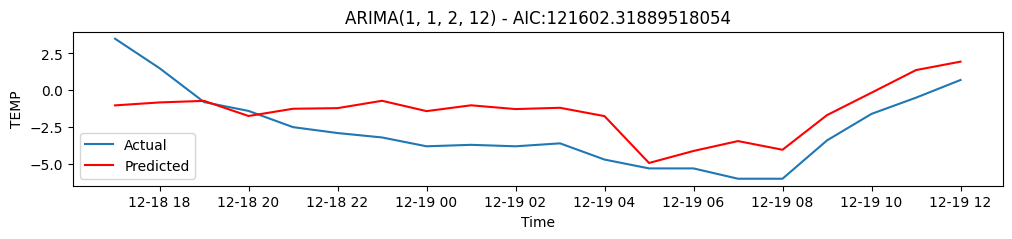

ARIMA(2, 1, 0, 12) - AIC:127408.08088715383


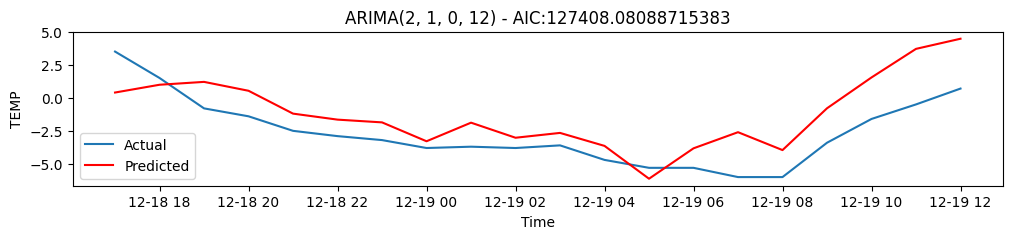

ARIMA(2, 1, 1, 12) - AIC:122561.35902042582


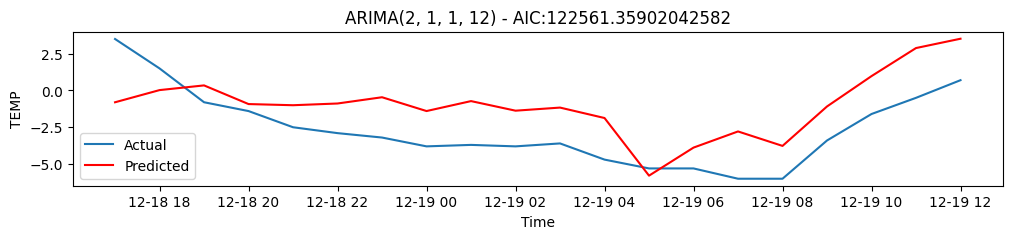

ARIMA(2, 1, 2, 12) - AIC:121468.13338152834


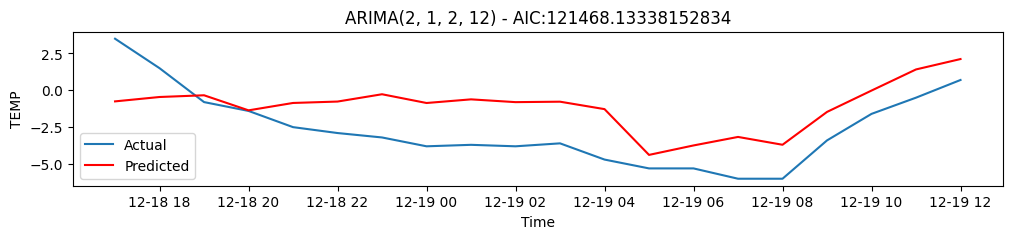


The best model is ARIMA(2, 1, 2, 12), AIC = 121468.13338152834
                                  SARIMAX Results                                  
Dep. Variable:                        TEMP   No. Observations:                24545
Model:             ARIMA(2, 1, [1, 2], 12)   Log Likelihood              -60729.067
Date:                     Sat, 24 Feb 2024   AIC                         121468.133
Time:                             10:43:34   BIC                         121508.672
Sample:                         03-01-2013   HQIC                        121481.266
                              - 12-18-2015                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.005      0.995]
------------------------------------------------------------------------------
ar.S.L12      -0.8122      0.010    -82.759      0.000      -0.837      -0.787
ar.S.L24       0.1871      

In [48]:
import warnings
warnings.filterwarnings("ignore")  
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA  
import itertools

# 定义季节性参数 P 和 Q，取0到2之间的任意值
P = Q = range(0, 3)  # D固定为1
s = 12  # 季节性周期，这里设置为12，表示年度季节性

# 生成P和Q的组合，并创建季节性参数列表
seasonal_pdq = [(x[0], 1, x[1], s) for x in list(itertools.product(P, Q))]


# 将数据分为训练集和测试集
train_data = df['TEMP'][:24545]  
test_data = df['TEMP'].iloc[24545:]  

best_model = None  # 初始化最优模型
best_seasonal_param = None  # 初始化最优季节性参数
best_aic = float('inf')  # 初始化最优模型的AIC值，初始值设置为无穷大

# 对所有的季节性参数组合进行遍历
for seasonal_param in seasonal_pdq:
    try:
        # 建立季节性ARIMA模型
        model = ARIMA(endog = train_data, seasonal_order=seasonal_param)  
        model_fit = model.fit()  # 拟合模型

        aic = model_fit.aic  # 获取当前模型的AIC值

        # 如果当前模型的AIC小于最优AIC，则更新最优模型、最优季节性参数和最优AIC
        if aic < best_aic:
            best_model = model_fit
            best_seasonal_param = seasonal_param
            best_aic = aic

        print(f'ARIMA{seasonal_param} - AIC:{aic}')

        # 生成预测结果的开始时间和结束时间
        start = len(train_data)
        end = start + len(test_data) - 1

        # 使用当前模型进行预测
        predictions = model_fit.predict(start=start, end=end, dynamic=True)

        # 画图展示真实值和预测值
        plt.figure(figsize=(12, 2))
        plt.plot(df.index[24545:24565], df['TEMP'].iloc[24545:24565], label='Actual')
        plt.plot(df.index[24545:24565], predictions.iloc[:20], color='red', label='Predicted')

        plt.title(f'ARIMA{seasonal_param} - AIC:{aic}')
        plt.xlabel('Time')
        plt.ylabel('TEMP')
        plt.legend()

        plt.show()

    except Exception as e:
        # 如果建立模型或者拟合模型出错，打印出错误信息
        print('Error:', e)
        continue

# 打印出最优模型的季节性参数和AIC
print(f'\nThe best model is ARIMA{best_seasonal_param}, AIC = {best_aic}')

# 打印最优模型的摘要信息
print(best_model.summary(alpha=0.01))

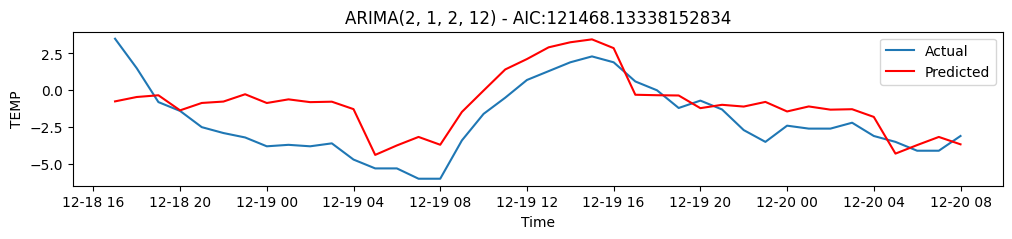

In [56]:
model = ARIMA(endog = train_data, seasonal_order=(2,1,2,12))  
model_fit = model.fit()  # 拟合模型

# 生成预测结果的开始时间和结束时间
start = len(train_data)
end = start + len(test_data) - 1

# 使用当前模型进行预测
predictions = model_fit.predict(start=start, end=end, dynamic=True)

# 画图展示真实值和预测值
plt.figure(figsize=(12, 2))
plt.plot(df.index[24545:24585], df['TEMP'].iloc[24545:24585], label='Actual')
plt.plot(df.index[24545:24585], predictions.iloc[:40], color='red', label='Predicted')

plt.title(f'ARIMA{seasonal_param} - AIC:{aic}')
plt.xlabel('Time')
plt.ylabel('TEMP')
plt.legend()

plt.show()

In [57]:
# 创建一个新的DataFrame来存储真实值和预测值
comparison_df = pd.DataFrame({'Actual': df['TEMP_Diff_1'].iloc[24545:], 'Predicted': predictions})

# 打印比对结果
print(comparison_df.head(20))

                     Actual  Predicted
2015-12-18 17:00:00    -2.2  -0.752009
2015-12-18 18:00:00    -2.0  -0.454438
2015-12-18 19:00:00    -2.3  -0.337512
2015-12-18 20:00:00    -0.6  -1.360274
2015-12-18 21:00:00    -1.1  -0.859134
2015-12-18 22:00:00    -0.4  -0.763774
2015-12-18 23:00:00    -0.3  -0.268057
2015-12-19 00:00:00    -0.6  -0.861702
2015-12-19 01:00:00     0.1  -0.614567
2015-12-19 02:00:00    -0.1  -0.803295
2015-12-19 03:00:00     0.2  -0.773025
2015-12-19 04:00:00    -1.1  -1.277456
2015-12-19 05:00:00    -0.6  -4.383354
2015-12-19 06:00:00     0.0  -3.741923
2015-12-19 07:00:00    -0.7  -3.164237
2015-12-19 08:00:00     0.0  -3.695386
2015-12-19 09:00:00     2.6  -1.467332
2015-12-19 10:00:00     1.8  -0.018166
2015-12-19 11:00:00     1.1   1.415691
2015-12-19 12:00:00     1.2   2.120711


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 计算均方误差
mse = mean_squared_error(df['TEMP_Diff_1'].iloc[24545:], predictions)
print("Mean Squared Error (MSE):", mse)

# 计算平均绝对误差
mae = mean_absolute_error(df['TEMP_Diff_1'].iloc[24545:], predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算均方根误差
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 4.437755571038877
Mean Absolute Error (MAE): 1.5757172935277004
Root Mean Squared Error (RMSE): 2.1065981038249504
